# Import Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19, MobileNetV2 ,InceptionV3
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Read Dataset

In [12]:
df = pd.read_csv("data.csv")
df["file_path"] = df["mood"]+'/'+df["filename"].str.split(".",expand=True)[0]+".png"

In [46]:
len(df)

396

# Define Constant

In [13]:
base_dir = "spectogram/"
IMAGE_SIZE = 256
BATCH_SIZE = 128

# Split Dataset

In [14]:
# Train 0.75
# Validate 0.15
# Test 0.10
df_train,  test_df = train_test_split(df,train_size=0.9,random_state=1941,stratify=df['mood'])
train_df, val_df = train_test_split(df_train,test_size=1/6,random_state=1941,stratify=df_train['mood'])

# Load image to generator

In [15]:
from keras_preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255,)

train_data = train_image_generator.flow_from_dataframe(
    train_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 296 validated image filenames belonging to 6 classes.


In [16]:
val_image_generator = ImageDataGenerator(rescale=1./255)

val_data = val_image_generator.flow_from_dataframe(
    val_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 60 validated image filenames belonging to 6 classes.


In [17]:
test_image_generator = ImageDataGenerator(rescale=1./255)

test_data = test_image_generator.flow_from_dataframe(
    test_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 40 validated image filenames belonging to 6 classes.


## Check Class indices

In [18]:
train_data.class_indices

{'Anxious': 0, 'Chill': 1, 'Focus': 2, 'Party': 3, 'Romance': 4, 'Sad': 5}

# Create model

In [29]:
def get_mobilenet_model():
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dropout(0.3)(headModel)
  headModel = Dense(64, activation="relu")(headModel)
  headModel = Dense(6, activation="softmax")(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)
  for layer in baseModel.layers:
    layer.trainable = False
  return model

In [30]:
model = get_mobilenet_model()
model_name = "model.h5"

In [31]:
model.compile(
    loss='categorical_crossentropy',
    # optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    optimizer="adam",
    metrics=['accuracy'])

In [32]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "models/"+model_name, save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

In [33]:
EPOCHS = 50
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, batch_size=256, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


2022-03-09 20:09:54.158262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 1.8489 - accuracy: 0.2568

2022-03-09 20:09:58.591290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 7s 1s/step - loss: 1.8489 - accuracy: 0.2568 - val_loss: 1.6329 - val_accuracy: 0.3333
Epoch 2/50
3/3 [==============================] - 3s 842ms/step - loss: 1.6368 - accuracy: 0.3446 - val_loss: 1.5019 - val_accuracy: 0.3833
Epoch 3/50
3/3 [==============================] - 3s 846ms/step - loss: 1.4912 - accuracy: 0.4291 - val_loss: 1.4088 - val_accuracy: 0.4333
Epoch 4/50
3/3 [==============================] - 3s 854ms/step - loss: 1.4095 - accuracy: 0.4257 - val_loss: 1.3068 - val_accuracy: 0.4833
Epoch 5/50
3/3 [==============================] - 2s 1s/step - loss: 1.3046 - accuracy: 0.5000 - val_loss: 1.2305 - val_accuracy: 0.5000
Epoch 6/50
3/3 [==============================] - 2s 772ms/step - loss: 1.2273 - accuracy: 0.5473 - val_loss: 1.1733 - val_accuracy: 0.5500
Epoch 7/50
3/3 [==============================] - 2s 758ms/step - loss: 1.1512 - accuracy: 0.5912 - val_loss: 1.1376 - val_accuracy: 0.5500
Epoch 8/50
3/3 [=====================

In [44]:
import os
confusion_matrix_s = np.zeros(36).reshape(6,6)
true = 0
class_labels = list(train_data.class_indices.keys())
count = 0
for i in test_df.itertuples():
    img = tf.keras.preprocessing.image.load_img(
        os.path.join(base_dir,i[3]), target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255
    img_array = img_array.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3)
    predictions = model.predict(img_array)
    pred_class = class_labels[np.argmax(predictions)]   
    row = class_labels.index(pred_class)
    col = class_labels.index(i[2])
    confusion_matrix_s[row][col] += 1
    if pred_class == i[2]:
        true+=1
    count += 1
    if count % 10 == 0:
        print("Done: ",count, "Acc:", round(true/count,4))

Done:  10 Acc: 0.7
Done:  20 Acc: 0.75
Done:  30 Acc: 0.7333
Done:  40 Acc: 0.775


# Save Model

In [ ]:
model.save("models/"+model_name)

# Load Model

In [ ]:
model = load_model("models/"+model_name)

# Evaluate Model

0.775


/var/folders/q1/qjttjhc15mb146h6q363vh_80000gn/T/ipykernel_5802/873049592.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["",*class_labels])
/var/folders/q1/qjttjhc15mb146h6q363vh_80000gn/T/ipykernel_5802/873049592.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["",*class_labels])


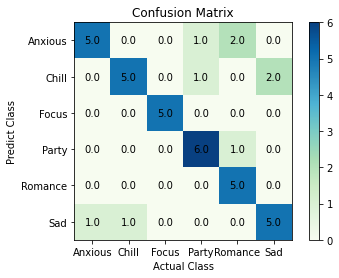

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title("Confusion Matrix")
heatmap = ax.matshow(confusion_matrix_s,cmap='GnBu')
plt.xlabel("Actual Class")
plt.ylabel("Predict Class")
plt.colorbar(heatmap)
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(["",*class_labels])
ax.set_yticklabels(["",*class_labels])
for (i, j), z in np.ndenumerate(confusion_matrix_s):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
accuracy = np.trace(confusion_matrix_s)/np.sum(confusion_matrix_s)
print(accuracy)